# Plane Wave Fitting on Simulated Data
14th December,2021  \
Author: Reet Mhaske \
Reference: https://gfzpublic.gfz-potsdam.de/rest/items/item_43213_6/component/file_56078/content

plane wave fitting by iterating over all possible values of phi \
On multiple iterations of the code, it was observed that the estimated backazimuth is independent of the the initial velocity \
hence, we start with v=2000m/s and later on finding the estimate for backazimuth, we find the velocity of wave assuming that \
the wave propagates along the line of backazimuth, and by using the data of receivers that line on this line

In [1]:
# importing the requiered libraries

import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import random
random.seed(0)
np.random.seed(0)

import toa as toa 

funtion that returns time of wave onset in the detector 

In [2]:
def time_measured(t,xdatafile,ydatafile,df=810):
    x_data=np.array(toa.pd.read_csv(xdatafile))
    y_data=np.array(toa.pd.read_csv(ydatafile))
    time=np.linspace(0,t,810)
    time_arrival_x=toa.time_of_arrival(x_data,time,df=810)
    time_arrival_y=toa.time_of_arrival(y_data,time,df=810)
     
    time_arrival=np.add(time_arrival_x,time_arrival_y)/2
 
    return time_arrival
    

(100, 810)


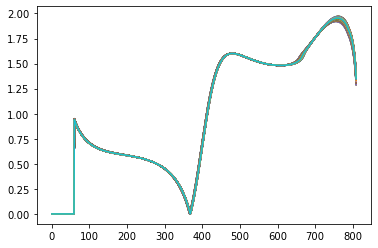

In [3]:
t=20
x_data=np.array(toa.pd.read_csv('recx_data_circ100.csv'))
y_data=np.array(toa.pd.read_csv('recy_data_circ100.csv'))
time=np.linspace(0,t,810)
time_arrival_x=toa.time_of_arrival(x_data,time,df=810)
time_arrival_y=toa.time_of_arrival(y_data,time,df=810)
     
time_arrival=np.add(time_arrival_x,time_arrival_y)/2
print(np.shape(x_data))


##### initialize no. of receivers, apparent horizontal velocity of sound, max frequency of source 

In [4]:
n_rec=100# number of receivers, to be kept odd for first run

rec_pos_act= np.zeros(shape =(n_rec,2))  # Assigning thr actual receiver position

v = 2000# m/s ### velocity of propagation (in sand)
freq=10 #Hz, max recorded frequency
lamda=v/freq# wavelength
distance_limit=2000#m,  l=2000m  > 10 times lamda 

##### initialize position of source and  receivers 

In [5]:
#setting source configuration randomly

#-->a=random.randrange(distance_limit-distance_limit/10,distance_limit*5) # sourec distance must be more than or equal to d , limits set here are arbitary within this acceptance
#-->b=random.randrange(distance_limit-distance_limit/10,distance_limit*5)
#-->src=(b,a)
#-->random.randrange(distance_limit-distance_limit/10,distance_limit*5)

#new source
src=(1000-11000,1000-11000)
#setting different receiver configurations

#uncomment following line for random distribution
rec_pos_act=np.random.normal(0,100,size=(n_rec,2))


#uncomment following line for linear distribution
#-->for i in range(0,n_rec):
    #rec_pos_act[i,1]=0
    #rec_pos_act[i,0]=(i-(n_rec-1)/2)*5 #first receievr at (-50,0) last at (50,0), all in line, distance 5 between them 


#uncomment following line for circular distribution    
#for i in range(0,n_rec):
 #   rec_pos_act[i,0]=100*cos(i*2*np.pi/n_rec)
  #  rec_pos_act[i,1]=100*sin(i*2*np.pi/n_rec) 
x_pos=np.array(toa.pd.read_csv('recx_pos_circ100.csv'))
y_pos=np.array(toa.pd.read_csv('recy_pos_circ100.csv'))
#rec_pos_act[0]=(0,0) #first receiver always at origin
rec_pos_act[:,0]=x_pos.reshape(100,)
rec_pos_act[:,1]=y_pos.reshape(100,)
rec_pos_act-=(11000,11000)




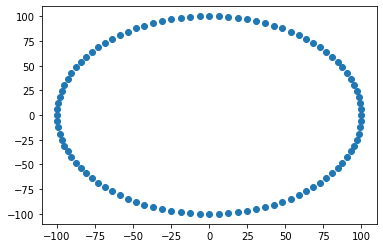

In [6]:
plt.scatter(rec_pos_act[:,0],rec_pos_act[:,1])

initialize time recordings by time of arrival, introduce noise in time and position

(100, 1)
(100, 1)
rec_pos_mes:   (100, 2)  t_Rec_real:  (100, 1)


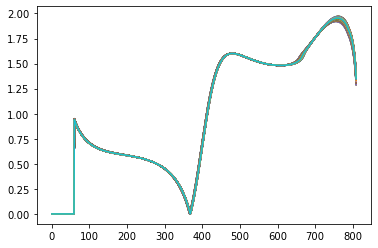

In [11]:
import random

t_rec_ideal = np.zeros(shape =(n_rec,))  # time recorded in each receiver; form: (index of receiver,time) 


t_noise=np.random.normal(0,5/2000,size=(n_rec,1))

#introduce noise in position
rec_pos_noise=np.random.normal(0,5,size=(n_rec,2))

rec_pos_mes= rec_pos_act  + rec_pos_noise  # rec_pos_mes stores[(x1,y1),(x2,y2),..] 



#initialising time recordings

#-->for i in range (0,n_rec):
 #-->   t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_mes[0:n_rec,0]-src[0])**2 + (rec_pos_mes[0:n_rec,1]-src[1])**2)/v


#redefine the time recordings from data files

t_rec_ideal=time_measured(20,'recx_data_circ100.csv','recy_data_circ100.csv')
print(np.shape(t_rec_ideal))
print(np.shape(t_noise))


### t_Rec_real has form [[rec1 recording], [rec2 recording]]




# introduce noise in time
t_Rec_real=t_rec_ideal + t_noise

invert=random.sample(range(0,n_rec-1),int(n_rec/2))
for i in invert:
    t_Rec_real[i]=-t_Rec_real[i]
#time difference between time recordings wrt receiver 1st rec, 
#in the form : time recorded by receiver at ith position - time recorded by 1st receiver 
t_diff=np.zeros(shape=(n_rec,))
for i in range(0,n_rec):
    t_diff[i]=t_rec_ideal[i]-t_rec_ideal[0]
    
print("rec_pos_mes:  ",np.shape(rec_pos_mes)," t_Rec_real: ",np.shape(t_Rec_real))   
    
    
    

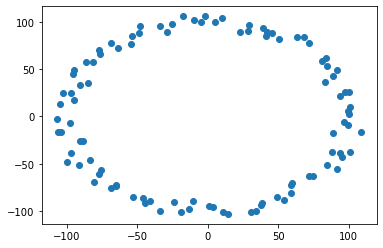

In [12]:
plt.scatter(rec_pos_mes[:,0],rec_pos_mes[:,1])

We iterate over all values of the backazimuth $\phi$ such that it minimizes the error expression for 
N receivers:
$\hat{s} = \min_{s}\sum_{i=1}^{N} (\tau_{i} - r_{i}.s)^2 $
where i is the index of the receivers
$\tau_{i}$ is the time difference for $i^{th}$ receiver
where the slowness vector $\vec{s}$ is defined as:
$\vec{s} = (-\frac{\sin{\phi}}{v}, -\frac{\cos{\phi}}{v})$

In [13]:
#function to return the error expression for a particular s, v and given configuration of receivers : 

def sum_of_errors(s_x,s_y,n_rec,rec_loc,time_diff):
    ''' returns the error expression for particular  slowness vector s , apparent horizontal velocity v, receiver positions, and time differences\
        input s in form of s_x and s_y ( x and y coordinate ) \
        input n_rec: number of receivers \
        input rec_loc: 2-D array for receiver location , in form [(x_1,y_1),...(x_n_rec,y_n_rec)]\
        input time_diff: 1-D array for time difference [(t_i)]'''  
    soe=0 # sume of errors
    # find sum over all receivers
    for i in range (0,n_rec):
        soe+=(time_diff[i]-s_x*rec_loc[i,0]-s_y*rec_loc[i,1])**2
    return soe    

In [14]:
#function to estimate slowness by iterating over backazimuth

def estimate_backazimuth(v,n_rec,rec_loc,time_diff):
    ''' returns estimated backazimuth and final error for the estimated backazimuth\
    input v: apparent horizontal velocity\
    inputn_rec: number of receivers\
    input rec_loc: 2-D array for receiver locations in form [(x_1,y_2)]\
    input time_diff: 1-D array for time difference [(t_i)]'''
    phi_estimated=0
    error=10000
    phi_range = np.linspace(0,2*np.pi,200000)
    for phi in phi_range :
            soe=sum_of_errors(-np.sin(phi)/v,-np.cos(phi)/v,n_rec,rec_loc,time_diff)  
            #print(s_x_temp,s_y_temp)
            #print(soe)
            #print(s_x_temp,s_y_temp
            if ( error>soe):
                error =soe
                phi_estimated=phi
    if (sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)<error) :
        error=sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)
        phi_estimated=np.pi-phi_estimated
    return (phi_estimated,error)  

Calling the above function to estimate velocity and error

In [15]:
phi_actual=np.arctan2(src[0],src[1]) #y first for arctan2,rotate axis (N is x now), so input x first
if (phi_actual<0):
    phi_actual+=2*np.pi
              
print("actual angle: ", phi_actual)
phi_estimated,final_error=estimate_backazimuth(v,n_rec,rec_pos_mes,t_diff)
print("phi_estimated :",phi_estimated,"\nfinal_error: ", final_error)

index_of_nearest_chip=int((5*np.pi/2-phi_estimated)%(2*np.pi)*100/(2*np.pi))
index_of_farthest_chip=int((5*np.pi/2-phi_estimated-np.pi)%(2*np.pi)*100/(2*np.pi))

print("index of receiver nearest to src on estimated backazimuth line: ",index_of_nearest_chip)
print("index of receiver farthest from src on estimated backazimuth line:   ", index_of_farthest_chip)
print("index of receiver to receive the wave first: ",list(t_Rec_real).index(t_Rec_real.min()))
print("indx of receiver to receive the wave last: ",list(t_Rec_real).index(t_Rec_real.max()))
print("index of receiver nearest to src on actual backazimuth line:   ",int((5*np.pi/2-phi_actual)%(2*np.pi)*100/(2*np.pi)))
print("index of receiver farthest from src on actual backazimuth line:   ",int((5*np.pi/2-phi_actual-np.pi)%(2*np.pi)*100/(2*np.pi)))



v=(np.sqrt(np.sum(np.square(np.subtract(rec_pos_mes[index_of_farthest_chip],rec_pos_mes[index_of_nearest_chip] )))))/\
(t_Rec_real[index_of_farthest_chip]-t_Rec_real[index_of_nearest_chip])/10
print(v) 

d=v*(t_Rec_real[index_of_nearest_chip]+t_Rec_real[index_of_farthest_chip])/2
print("difference in backazimuth: ",phi_estimated-phi_actual,"\npercentage error in backazimuth: ",((phi_estimated)/phi_actual-1)*100,"%"  )
#src_position_estimated=(t)
estimated_position=(d*np.sin(phi_estimated),d*np.cos(phi_estimated))
print("d: ",d,"estimated position: ", estimated_position)
diff_in_loc=np.sqrt(np.sum(np.square(np.subtract(estimated_position,src))))
print("diff in location: " ,  diff_in_loc,"m ")

print("percentage error in position: ",diff_in_loc/(np.sqrt(src[0]**2+src[1]**2) )*100,"%")


actual angle:  3.92699081699
phi_estimated : 3.95883494474 
final_error:  0.0931707456142
index of receiver nearest to src on estimated backazimuth line:  61
index of receiver farthest from src on estimated backazimuth line:    11
index of receiver to receive the wave first:  12
indx of receiver to receive the wave last:  15
index of receiver nearest to src on actual backazimuth line:    62
index of receiver farthest from src on actual backazimuth line:    12
[ 0.99439599]
difference in backazimuth:  0.0318441277556 
percentage error in backazimuth:  0.81090405452 %
d:  [ 0.00336971] estimated position:  (array([-0.0024574]), array([-0.00230568]))
diff in location:  19999.9952369 m 
percentage error in position:  141.421322557 %


After knowing the backazimuth, we find the indices of receivers that lie on this line of  estimated backazimuth \
We find the indices of receivers ling along the line of true backazimuth and also the one that receive the wave the first and \
last (labeled the nearest and farthest from src respectively)

In [16]:
index_of_nearest_chip=int((5*np.pi/2-phi_estimated)%(2*np.pi)*100/(2*np.pi))
index_of_farthest_chip=int((5*np.pi/2-phi_estimated-np.pi)%(2*np.pi)*100/(2*np.pi))

print("index of receiver nearest to src on estimated backazimuth line: ",index_of_nearest_chip)
print("index of receiver farthest from src on estimated backazimuth line:   ", index_of_farthest_chip)
print("index of receiver to receive the wave first: ",list(t_Rec_real).index(t_Rec_real.min()))
print("indx of receiver to receive the wave last: ",list(t_Rec_real).index(t_Rec_real.max()))
print("index of receiver nearest to src on actual backazimuth line:   ",int((5*np.pi/2-phi_actual)%(2*np.pi)*100/(2*np.pi)))
print("index of receiver farthest from src on actual backazimuth line:   ",int((5*np.pi/2-phi_actual-np.pi)%(2*np.pi)*100/(2*np.pi)))

index of receiver nearest to src on estimated backazimuth line:  61
index of receiver farthest from src on estimated backazimuth line:    11
index of receiver to receive the wave first:  12
indx of receiver to receive the wave last:  15
index of receiver nearest to src on actual backazimuth line:    62
index of receiver farthest from src on actual backazimuth line:    12


In [17]:
v=np.sqrt(np.sum(np.square(np.subtract(rec_pos_mes[index_of_farthest_chip],rec_pos_mes[index_of_nearest_chip] ))))/ \
                                    (t_Rec_real[index_of_farthest_chip]-t_Rec_real[index_of_nearest_chip])
#finding velocity using the receivers that lie on the line of estimated backazimuth
print(v)


[ 9.94395986]


### The velocity of propagation
the estimated velocity is greater than the permissible range ( ~1000m/s to 2000 m/s), we manually scale it down by 10

In [18]:
v=v/10

We plot the wave onset time for the receivers, \
the receiver hae been indexed starting from the receiever at y=, and positive x extreme of the circle and going anticlockwise 

Text(0, 0.5, 'time of wave onset (in sec)')

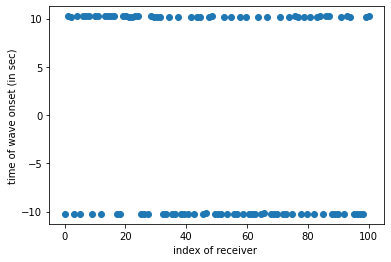

In [19]:
plt.scatter(np.linspace(0,100,100),t_Rec_real)
plt.xlabel('index of receiver ')
plt.ylabel('time of wave onset (in sec)')


In [20]:

print("pi- phi_estimated :",np.pi-phi_estimated)
print(" difference in backazimuth (diff of pi): ",np.pi-phi_estimated-phi_actual," percentage error : ",((np.pi-phi_estimated)/phi_actual-1)*100,"%"  )


pi- phi_estimated : -0.817242291153
 difference in backazimuth (diff of pi):  -4.74423310814  percentage error :  -120.810904055 %


###  Plot the results 

In [21]:
x=np.linspace(0,2*np.pi,2000)
y=np.zeros(shape=(2000,))
for i in range(0,2000):
    y[i]=sum_of_errors(-sin(x[i])/v,-cos(x[i])/v,n_rec,rec_pos_mes,t_diff)

Text(0, 0.5, 'error in arbitary units')

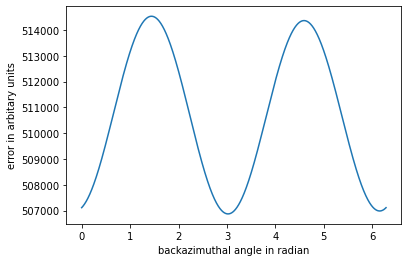

In [22]:
plt.plot(x,y)
plt.xlabel("backazimuthal angle in radian")
plt.ylabel("error in arbitary units")


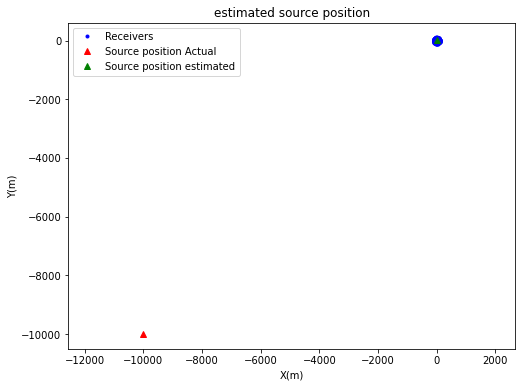

In [23]:
x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position


plt.figure(figsize=(8,6))
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')
d=v*t_Rec_real[0]
plt.plot(d*np.sin(phi_estimated),d*np.cos(phi_estimated),'g^',label='Source position estimated')

#plt.plot(d*np.sin(np.pi-phi_estimated),d*np.cos(np.pi-phi_estimated),'g^',label='Source position estimated')
#plt.plot(d*np.sin(np.pi/2-phi_estimated),d*np.cos(np.pi/2-phi_estimated),'g^',label='Source position estimated')
plt.plot()
plt.legend()
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')

plt.title('estimated source position')
plt.show()

     

Key Limitations:

Cause of the error is because the estimated position assumes that first receiver (at index 0) is at origin 

Configurations tried so far:
linear,
gaussian(negative results),
circular

Noise introduced in position has standard deviation 2.5m; and that in time has standard deviation 5/v

Distance of source from receivers should be more than 10 times the wavelength

the error in backazimuth is magnified on multiplying by distance as is observed 

In [24]:
def src_Loc(rec_pos, t_rec,c,src_pos):
    '''The function returns the difference between the position of source(guessed) and receiver location as calculated from 
    measurement of time difference of arrival with the distance calculated from position of source and receiver. We aim to 
    minimise this quantity

    rec_pos = a matrix with position of receivers stored in the following format [[x_1, y_1],[x_2,y_2]]
    t_rec  = the time of arrival as measured from data
    source_loc = the guessed source location for which the function is being evaluated
    
    '''
    
    n_rec = np.shape(rec_pos)[0]
    t_rec_rel1 = np.zeros(shape=(n_rec-1,1))   # time difference calculated wrt the value in first receiver
    
    t_rec_rel1[:] = t_rec[1:] -t_rec[0]     
    
    rec_pos_src_rel = np.zeros(shape =(n_rec-1,2)) # Calculating the relative position of recivers wrt the source
    
    rec_pos_src_rel[:] = rec_pos[1:] -src_pos*np.ones_like(rec_pos_src_rel)  # relative position of receiver 1 wrt the source
    
    rec1_pos_src_rel = rec_pos[0] -src_pos # the position of receiver one wrt the source
    
    rec_dist_src_rel = np.zeros(shape=(n_rec-1,1))
    
    rec1_dist_src_rel = np.sqrt(rec1_pos_src_rel[0]**2 + rec1_pos_src_rel[1]**2)
    
    rec_dist_src_rel[:] = np.sqrt(rec_pos_src_rel[:,0]**2 + rec_pos_src_rel[:,1]**2).reshape(n_rec-1,1)
    
    delta_r = t_rec_rel1*c
    
    error = np.zeros(shape =(n_rec-1,1))   # defing the error to be minimized
    error[:] = delta_r[:] - (rec_dist_src_rel[:]-rec1_dist_src_rel)   
    
    error_to_min =np.dot(error.T,error) # Getting a single value instead of an array
    
    return error_to_min

In [25]:
def error_in_tdoa(src_pos,time,rec_pos,n_rec):
    '''rec_pos=((x1,y1),)
      src_pos=(x,y)
    time=(t1,t2,...)'''
    time_estimated=np.zeros(shape=(n_rec,))
    for i in range(0,n_rec):
        r=np.sum(np.square(np.subtract(rec_pos[i],src_pos)))
        
        time_estimated[i]=(sqrt(r))/v
    err=np.sum(np.square(np.subtract(time_estimated,time)))
    return err

In [26]:
d=10000

import pandas as pd
iter_width=1000
theta_iter=5
r1=np.linspace(2*d,0,iter_width)
theta1=np.linspace(phi_estimated-5/180*np.pi,phi_estimated+5/180*np.pi,theta_iter)

r=r1.reshape(iter_width,)
theta=theta1.reshape(theta_iter,)

x=np.zeros(shape=(iter_width,theta_iter))
y=np.full_like(x,0)

print(np.shape(r))
print(np.shape(theta))
error=np.zeros(shape=(iter_width,theta_iter))

for i in range(0,iter_width):
    for j in range(0,theta_iter):
        error[i,j]=error_in_tdoa((r[i]*np.sin(theta[j]),r[i]*np.cos(theta[j])),t_Rec_real,rec_pos_mes,n_rec)
        x[i,j],y[i,j]=r[i]*np.sin(theta[j]),r[i]*np.cos(theta[j])

x_line=x.flatten()
y_line=y.flatten()
error_1D=error.flatten()
df = pd.DataFrame({'x':x_line,
                   'y':y_line,
                   'z':error_1D})



(1000,)
(5,)


actual source position :  -10000 -10000
estimated position:  -0.0 -0.0
percentage error in localization:  100.0 %


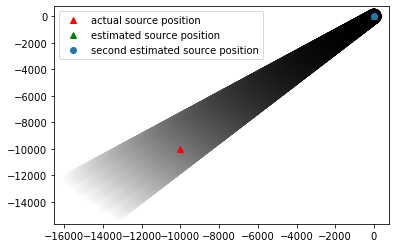

In [27]:

error_1D=error.flatten()
plt.scatter(df.x, df.y, s=200, c=df.z, cmap='gray')
plt.plot(src[0],src[1],'r^',label='actual source position')
estimate_index=list(error_1D).index(np.min(error_1D))
plt.plot(x_line[estimate_index],y_line[estimate_index],'g^',label='estimated source position')
#if(np.min(error[estimate_index+1:])==(error[estimate_index])):
est2_index=list(error_1D).index(np.min(error_1D[estimate_index+1:]))
plt.plot(x_line[est2_index],y_line[est2_index],'o',label='second estimated source position')
plt.legend()
#print(error_1D[est2_index],error_1D[estimate_index])
#print("estimated position: ",x_line[est2_index] ,y_line[est2_index] )
#plt.plot(x[np.where(error==np.min(error))],y[np.where(error==np.min(error))],'o')
print("actual source position : ",src[0], src[1])
print("estimated position: ",x_line[estimate_index] ,y_line[estimate_index] )
print("percentage error in localization: ", float(sqrt((x_line[estimate_index]-src[0])**2+(y_line[estimate_index]-src[1])**2)/sqrt(src[0]**2+src[1]**2)*100), "%")

In [28]:

error = np.zeros(shape=(1000,))  # To store the values at various points
rec_pos_modified = np.zeros_like(rec_pos_act)
rec_pos_modified[:] = rec_pos_act[:]  # Can modify later if required
x=np.linspace(-1.1*d*cos(phi_estimated),1.1*d*cos(phi_estimated),1000)
y=np.linspace(-1.1*d*sin(phi_estimated),1.1*d*sin(phi_estimated),1000)

for j in range(1000):
    error[i,j] = src_Loc_recpos_error(rec_pos_mes=rec_pos_mes,t_rec=t_Rec_real,c=v,src_pos=(x[j],y[j]),rec_pos_act=rec_pos_modified)
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-d,d)
plt.ylim(-d,d)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')


TypeError: Cannot interpret '7526.58387717328' as a data type

In [ ]:
x, y = np.meshgrid(np.linspace(0, 1, 2), np.linspace(0, 1, 2))
print(x,y)

In [ ]:
np.where([[True,False]],[[10,8],[13,90]],[[1,2],[3,4]])


In [ ]:
q=[1,0,1,2,4,0]
q.index(min(q))